In [1]:
import torch
import pandas as pd
import numpy as np
import glob, os
from scipy.spatial import KDTree
from scipy import ndimage
import imageio
import scipy
import h5py
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pickle
import logging
from multiprocessing import Pool


In [2]:
logger = logging.getLogger()
hdlr = logging.FileHandler(os.path.join('data_generator.log'))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.INFO)

In [3]:
v_list = sorted(glob.glob('/ktmp/videos/*/*'))
a_list = sorted(glob.glob('/ktmp/annotations/*/*'))
col_name = ["Track ID", "xmin", "ymin", "xmax", "ymax", "frame", "lost", "occluded", "generated", "label"]

def gaussian_filter_density(gt):
    '''
    convert one-hot map to gaussian filtered map
    @param gt: np.array with shape [h, w], one-hot encoded map
    @output density: a gaussian filtered hot map
    '''
    
#     print(gt.shape)
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.nonzero(gt)
    pts = np.vstack([pts[1], pts[0]]).T

    leafsize = 2048
    # build kdtree
    tree = KDTree(pts, leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

#     print('generate density...')
    for i, pt in enumerate(pts):
#         print(i, pt)
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
#     print('done.')
    return density

In [4]:
len(v_list)

60

In [ ]:
n_sample = 100
dump_dir = 'data/raw/'

if not os.path.exists(dump_dir):
    os.makedirs(dump_dir)

def data_gen(case):
# for case in range(len(v_list)):

    # load movie
    mov = imageio.get_reader(v_list[case] + '/video.mov', 'ffmpeg')

    # load annotation
    dp = pd.read_csv(a_list[case] + '/annotations.txt', sep=" ", header=None)
    dp.columns = col_name
    dp = dp[(dp.label == 'Biker') | (dp.label == "Pedestrian")].reset_index(drop = True)
    sampled_frames = dp.frame.sample(n=n_sample, random_state=9487) 
    
    # for each sampled frame
    for frame in sampled_frames:
        name = '{:02d}_{:06d}.h5'.format(case, frame)
        
        # skip
        if os.path.exists(dump_dir + name):
            logging.info('{} generated, skipped'.format(name))
            continue
        
        # get frame
        img = mov.get_data(frame)
        
        # get object coordinates
        objs = dp[dp.frame == frame]
        coordinates = []
        for id, obj in objs.iterrows():
            x, y = (obj.xmin + obj.xmax)/2, (obj.ymin + obj.ymax)/2
            coordinates.append([x, y])
        coordinates = np.array(coordinates)
        
        if coordinates.shape[0] < 4: # too few points
            logging.info('{} too few points, skipped'.format(name))
            continue
        
        hot_map = np.zeros((img.shape[0],img.shape[1]))
        
        try:
            for i in range(0,len(coordinates)):
                hot_map[int(coordinates[i][1]),int(coordinates[i][0])]=1
        except IndexError:
            logging.info('{} IndexError Exception, skipped'.format(name))
            continue
                
        hot_map = gaussian_filter_density(hot_map)
        
        with h5py.File(dump_dir + name, 'w') as hf:
            hf['img'] = img
            hf['map'] = hot_map
            
        logging.info('{} generated'.format(name))

with Pool(16) as p:
    r = list(p.imap(data_gen, range(len(v_list))))

In [ ]:
plt.figure(figsize = (20,20))
plt.imshow(hot_map)
print(np.max(hot_map))

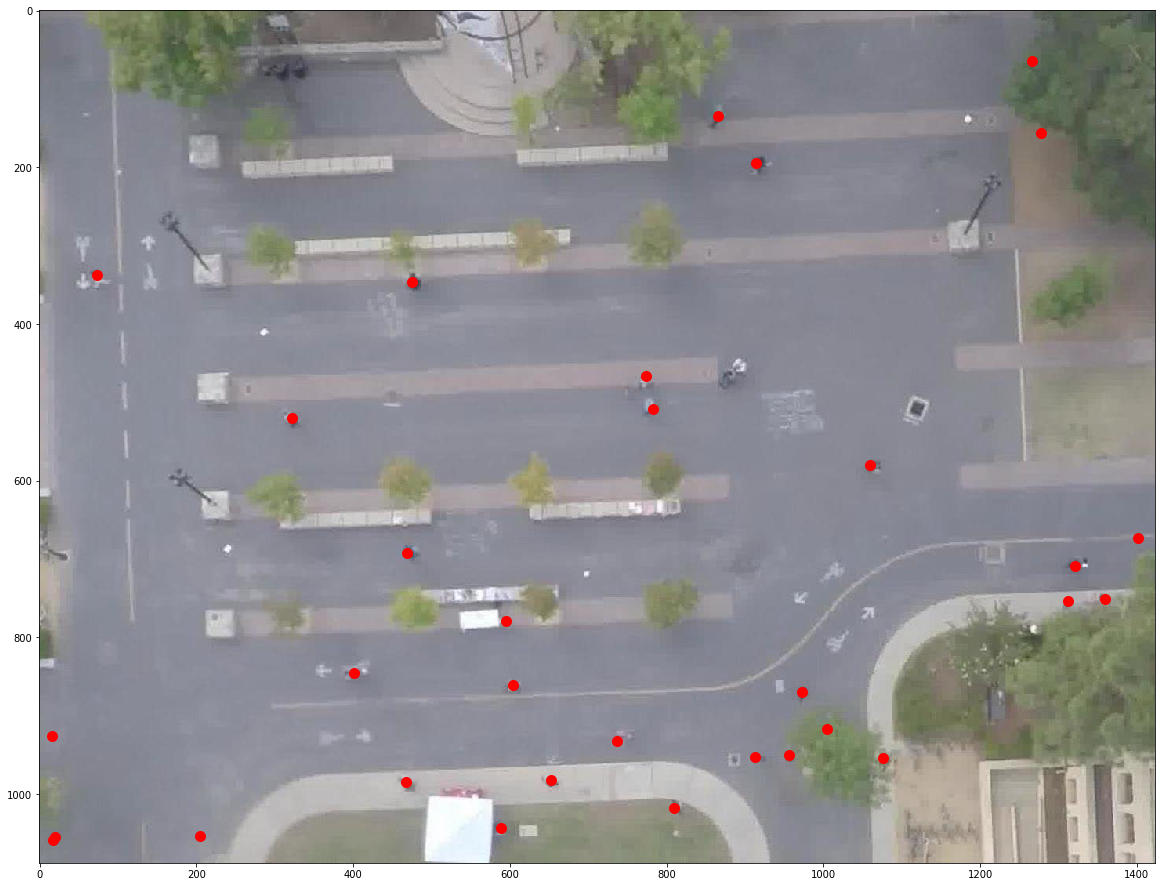

In [114]:
plt.figure(figsize = (20,20))
plt.imshow(img)
plt.plot(coordinates[:,0], coordinates[:,1], 'r', marker='.', ls = '', markersize = 20)